# Clean AdresMusea

## Import packages and set pandas options

In [1]:
import numpy as np
import pandas as pd
import tldextract
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pd.set_option('max_row', None)
pd.set_option('max_columns', None)

## Load CSV's

In [2]:
musea_df = pd.read_csv('musea.csv')
updated_musea_df = pd.read_csv('musea_updated.csv')
adres_musea = pd.read_excel('AdresData Musea.xlsx', header=1)
musea_df.drop_duplicates(subset=['translationSetId'], inplace=True)

# Museumnl Categories

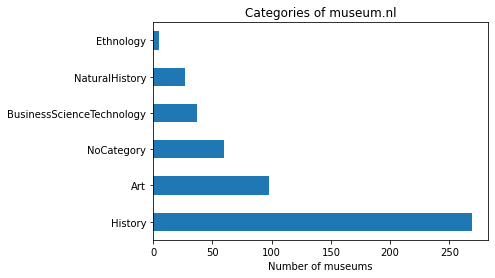

In [3]:
# x = musea_df['mainCategory'].value_counts(dropna=False)
musea_df.mainCategory.fillna("NoCategory", inplace=True)
cat_plot = musea_df.mainCategory.value_counts()
cat_plot.plot.barh()
plt.xlabel('Number of museums')
plt.title('Categories of museum.nl')
plt.savefig('categories_barh', dpi=300)

History                      358
Art                          152
NaN                           74
BusinessScienceTechnology     63
NaturalHistory                43
Ethnology                      6
Name: mainCategory, dtype: int64


/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


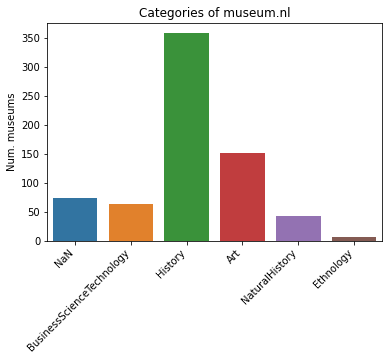

In [4]:
updated_musea_df.mainCategory.fillna("NaN", inplace=True)
print (updated_musea_df.mainCategory.value_counts())

# fig, ax = plt.subplots(figsize=(12,4))
fig, ax = plt.subplots(figsize=None)
sns.countplot(updated_musea_df['mainCategory'], ax=ax)
plt.title('Categories of museum.nl')
plt.ylabel('Num. museums')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.show()

## Edit and Compare by website

In [5]:
def uniform_website(df):   
    df['site_sld'] = df['website']
    df.site_sld = df['site_sld'].apply(lambda url: tldextract.extract(url).domain if type(url) == str else url)
    df.site_sld = df.site_sld.str.lower()
    
    return df

def compare_website(df1, df2):   
    
    df1 = uniform_website(df1)[['publicName', 'site_sld', 'translationSetId']]
    df2 = uniform_website(df2)[['site_sld', 'aantal bezoekers p/jr', 'museaal_thema']]
    df2 = df2.drop_duplicates(subset=['site_sld'])
    
    # Inner merge dataframes by SLD
    output = df1.merge(df2, how="inner", left_on='site_sld', right_on='site_sld')
    output.drop(['site_sld'], axis=1, inplace=True)
    
    return output

## Edit and Compare by museum name

In [6]:
def uniform_museum_name(df, column_name):
    # Clean columns to get uniform values
    df['naam'] = df[column_name]
    
    df.naam = df.naam.str.lower().str.replace('museum','')
    df.naam = df.naam.str.replace('de','')
    df.naam = df.naam.str.replace('het','')
    df.naam = df.naam.str.replace('[^\w\s]','')
    df.naam = df.naam.replace('\s+', ' ', regex=True)
    df.naam = df.naam.str.strip()
    
    return df

def compare_name(df1, df2):
    df1 = uniform_museum_name(df1, 'publicName')[['publicName', 'translationSetId', 'naam']]
    df2 = uniform_museum_name(df2, 'organisatie_naam')[['naam', 'aantal bezoekers p/jr', 'museaal_thema']]
    
    output = df1.merge(df2, how="inner", left_on='naam', right_on='naam')
    output.drop(['naam'], axis=1, inplace=True)

    return output

In [7]:
def concat_one_hot_dfs(df1, df2):
    site_df = compare_website(df1, df2)
    naam_df = compare_name(df1, df2)
    result = pd.concat([site_df, naam_df]).drop_duplicates().reset_index(drop=True)
    
    one_hot_cat = result.museaal_thema.str.get_dummies(', ')
    categories = pd.concat([result, one_hot_cat], axis=1)
    
    if 'overig' in categories:
        categories.drop(['museaal_thema', 'overig'], axis=1, inplace=True)
    else:
        categories.drop(['museaal_thema'], axis=1, inplace=True)
    
    category_dict = {"maritiem/scheepvaart": "Naval", "natuurhistorie": "Nature", 
                     "transport/technisch": "Tech", "archeologie/historie": "History", 
                     "aantal bezoekers p/jr": "Visitors", "cultuurhistorie": "Culture", 
                     "beeldende kunst": "Visual", "volkenkunde": "Ethnology"}
    
    for k, v in category_dict.items():
        if k in categories:
            categories.rename(columns={k:v}, inplace=True)
    
    categories.sort_values(by=['publicName'], axis=0, inplace=True)
    
    output = categories.groupby(['publicName', 'translationSetId'], as_index=False).agg('sum')
    missing = df1[~df1.translationSetId.isin(output.translationSetId)][['publicName', 'translationSetId']]
    
    result = output.append(missing)
    
    categories_eng = ['History', 'Visual', 'Culture', 'Naval', 'Nature', 'Tech','Ethnology']
    for x in categories_eng:
        if x in result:
            result.update(result[[x]].fillna(0))
    
    manual = pd.read_csv('handmatig_musea.csv', sep=';')
    output = result.append(manual, ignore_index=True)
    output.update(output[['History', 'Visual', 'Culture', 'Naval', 'Nature', 'Tech','Ethnology']].fillna(0))
    output.drop_duplicates(subset=['translationSetId'], keep='last', inplace=True)
    output = output.sort_values(by=['publicName']).reset_index(drop=True)
    
    return output

# Run script with df's

In [8]:
original = concat_one_hot_dfs(musea_df, adres_musea)
new = concat_one_hot_dfs(updated_musea_df, adres_musea)

In [9]:
new[~new['translationSetId'].isin(original['translationSetId'])]

,publicName,translationSetId,Visitors,History,Visual,Culture,Naval,Nature,Tech,Ethnology
62,Fashion for Good,3d48d03b-350c-449c-9f2a-2a4b71e16996,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,Historisch Museum Vriezenveen,4789c628-eddb-4bc5-b270-a1e7454c1b4c,5000.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
129,Huis van Hilde,f7d86ac9-4f08-4628-954b-0afec628135d,45000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
190,Luther Museum Amsterdam,1741c155-69f9-4e04-a47d-07555844dbed,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
313,Museum Vincentre | Van Gogh Village Nuenen,ad31f144-5a03-46d7-88b6-8ebd048bbabc,20000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
376,Nederlands Pluimveemuseum,4a0e3a07-7a4c-4e95-825b-a3b4ebb11c06,25000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
444,Storyworld | Forum Groningen,acfa8d9d-7062-4b90-b8fa-03a9d8535991,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,Van Eesteren Museum,90e9a9bf-284c-44c7-8934-b0475e7a33d1,3500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
469,Van ’t Lindenhoutmuseum,35feee30-9531-4f35-9b6f-1ac5bf58934f,4000.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


# Define small/large musea

In [10]:
def small_large(df):
    print ("num of matched musea with visitors:")
    print (df.Visitors.isna().value_counts())
    df = df.fillna(df.Visitors.median())
    df['small_museum'] = 0

    df.Visitors <= df.Visitors.median()

    mask = df.Visitors <= df.Visitors.median()
    column_name = 'small_museum'
    df.loc[mask, column_name] = 1
    
    return df

# Define Small/Large Museums

In [11]:
test_df = new[['Visitors']].dropna()
test_df.shape

(457, 1)

In [12]:
from scipy.stats import zscore

z_scores = zscore(test_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = test_df[filtered_entries]

new_df.shape

(451, 1)

In [13]:
new_df.describe()

,Visitors
count,451.000000
mean,51668.337029
std,82122.404121
min,0.000000
25%,8000.000000
50%,20000.000000
75%,55000.000000
max,540000.000000


In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.mean(new[['Visitors']]).values[0]

# len(hist_y[hist_y <= np.median(hist_y)])

67459.24726477024

In [15]:
hist_y = new.Visitors.dropna().sort_values().values
len(hist_y[hist_y < np.mean(new[['Visitors']]).values[0]])

359

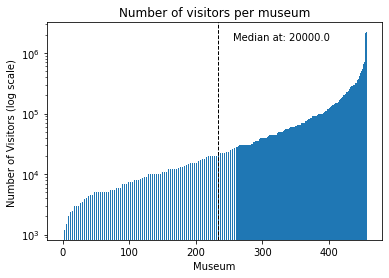

In [16]:
hist_y = new.Visitors.dropna().sort_values().values
hist_x = new.Visitors.dropna().sort_values().reset_index(drop=True).index
middle = len(hist_y[hist_y <= np.median(hist_y)])

ax = plt.axes(xscale='linear', yscale='log')

plt.bar(hist_x, hist_y, align='center')
plt.axvline(middle, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(middle*1.1, max_ylim*0.5, 'Median at: {:}'.format(np.median(hist_y)))
plt.title('Number of visitors per museum')
plt.xlabel('Museum')
plt.ylabel('Number of Visitors (log scale) ')
plt.savefig('museum_visitors', dpi=300)
plt.show()

In [17]:
output = small_large(new)
# output.to_csv('output_musea.csv', index=False)
print('-----')
print("Num of nan values in Visitors:", output.Visitors.isna().sum())
output.head()

num of matched musea with visitors:
False    457
True      48
Name: Visitors, dtype: int64
-----
Num of nan values in Visitors: 0


,publicName,translationSetId,Visitors,History,Visual,Culture,Naval,Nature,Tech,Ethnology,small_museum
0,ABC Architectuurcentrum Haarlem,3bcb3ba4-1675-461b-880e-2676f8c7def9,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
1,Afrika Museum,b5023390-ced1-4210-a14c-23c349b2ee15,70000.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0
2,Agrarisch Museum Westerhem,1c731866-d25c-489a-b1ea-1e04a1cca554,1200.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1
3,Airborne Museum at Hartenstein,a7e42402-9eb9-4312-abf5-ae09e951e068,120000.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0
4,Allard Pierson,6ed658b1-4ce7-4df9-9472-4b0271d044a3,90000.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0


# Append manual missing categories

In [18]:
missing_categories = output.loc[(output.History == 0) & (output.Visual == 0) & (output.Culture == 0) & (output.Naval == 0) & 
                                (output.Nature == 0) & (output.Tech == 0) & (output.Ethnology == 0)]
# missing_categories.to_csv('missing_categories.csv', index=False)
missing_categories.head()

,publicName,translationSetId,Visitors,History,Visual,Culture,Naval,Nature,Tech,Ethnology,small_museum
0,ABC Architectuurcentrum Haarlem,3bcb3ba4-1675-461b-880e-2676f8c7def9,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
9,"BAK, basis voor actuele kunst",ae32e45b-c9aa-4cc1-ac06-6ddb93c9630b,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
12,Beeld en Geluid,92f68db4-1a4e-4847-990b-9710c4696e9a,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
13,Beeld en Geluid Den Haag,97dca6c1-6b1a-4ffe-a048-83ecce6707a5,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
17,Biesbosch MuseumEiland,f61643e5-0237-4536-90ef-d3e8f721de21,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1


In [19]:
manual_missing_categories = pd.read_csv('missing_categories.csv', sep=';')
output = output.append(manual_missing_categories, ignore_index=True)
output.drop_duplicates(subset=['translationSetId'], keep='last', inplace=True)
output = output.sort_values(by=['publicName']).reset_index(drop=True)
output.to_csv('output_musea.csv', index=False)
output.head()

,publicName,translationSetId,Visitors,History,Visual,Culture,Naval,Nature,Tech,Ethnology,small_museum
0,ABC Architectuurcentrum Haarlem,3bcb3ba4-1675-461b-880e-2676f8c7def9,20000.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1
1,Afrika Museum,b5023390-ced1-4210-a14c-23c349b2ee15,70000.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0
2,Agrarisch Museum Westerhem,1c731866-d25c-489a-b1ea-1e04a1cca554,1200.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1
3,Airborne Museum at Hartenstein,a7e42402-9eb9-4312-abf5-ae09e951e068,120000.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0
4,Allard Pierson,6ed658b1-4ce7-4df9-9472-4b0271d044a3,90000.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0
